In [1]:
# Import Libraries
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Reading the Dataframe
train_df = pd.read_csv("/content/Train.csv")
test_df = pd.read_csv("/content/Test.csv")
val_df = pd.read_csv("/content/Validation.csv")

In [4]:
# set time as index
train_df.set_index('time', inplace=True)
test_df.set_index('time', inplace=True)
val_df.set_index('time', inplace=True)


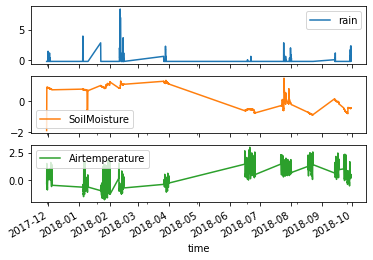

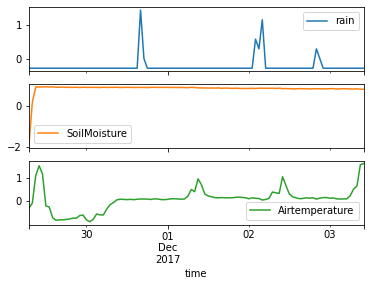

In [89]:
# plot the data - visual inspection for one sensor
plot_cols = ['rain', 'SoilMoisture', 'Airtemperature']

filtered_train_df = train_df.loc[train_df['Serial'] == train_df['Serial'][0]]

plot_features = filtered_train_df[plot_cols]
date_time = pd.to_datetime(filtered_train_df.index, format='%Y-%m-%dT%H:%M:%S')
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = filtered_train_df[plot_cols][0:100]
plot_features.index = date_time[0:100]
_ = plot_features.plot(subplots=True)

In [6]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
train_mean = train_df.mean()
train_std = train_df.std()

for x in ['Airtemperature', 'SoilMoisture', 'Longitude', 'Latitude', 'rain']:
  train_df[x] = (train_df[x] - train_mean[x]) / train_std[x]
  val_df[x] = (val_df[x] - train_mean[x]) / train_std[x]
  test_df[x] = (test_df[x] - train_mean[x]) / train_std[x]


<ipython-input-6-e381687e9cca>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_mean = train_df.mean()
<ipython-input-6-e381687e9cca>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_std = train_df.std()


"\n# Create an instance of the scaler\nscaler = MinMaxScaler()\n\n# Fit the scaler on your data\nscaler.fit(train_df['rain'].numpy())\n\n# Transform your data using the scaler\ntrain_df['rain'] = scaler.transform(train_df['rain'].numpy())\nval_df['rain'] = scaler.transform(val_df['rain'].numpy())\ntest_df['rain'] = scaler.transform(test_df['rain'].numpy())\n"

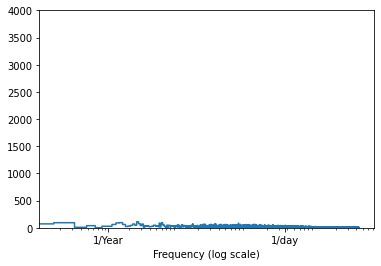

In [ ]:
# Use Forier series to find time seasonality
fft = tf.signal.rfft(train_df['rain'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(train_df['rain'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 4000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

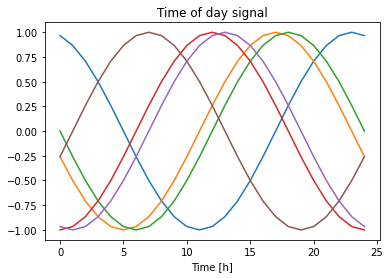

In [7]:
# Converting time into sine and cosine transforms to account for perodicity
for df in [train_df, test_df, val_df]:

  df['Date Time'] = df.index
  date_time = pd.to_datetime(df.pop('Date Time'), format='%Y-%m-%d %H:%M:%S')

  timestamp_s = date_time.map(pd.Timestamp.timestamp)

  day = 24*60*60
  year = (365.2425)*day

  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  plt.plot(np.array(df['Day sin'])[:25])
  plt.plot(np.array(df['Day cos'])[:25])
  plt.xlabel('Time [h]')
  plt.title('Time of day signal')

In [8]:
# check data
test_df

,Serial,Longitude,Latitude,Airtemperature,SoilMoisture,rain,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,,
2017-12-06T12:00:00.000Z,PI040298AA3L032108,1.620440,-1.694841,-0.414008,0.666786,-0.261728,2.863218e-12,-1.000000,-0.419122,0.907930
2017-12-06T13:00:00.000Z,PI040298AA3L032108,1.620440,-1.694841,-0.437906,0.675060,-0.261728,-2.588190e-01,-0.965926,-0.418471,0.908230
2017-12-06T14:00:00.000Z,PI040298AA3L032108,1.620440,-1.694841,-0.827483,0.667593,-0.261728,-5.000000e-01,-0.866025,-0.417820,0.908530
2017-12-06T15:00:00.000Z,PI040298AA3L032108,1.620440,-1.694841,-1.013434,0.664970,-0.261728,-7.071068e-01,-0.707107,-0.417168,0.908829
2017-12-06T16:00:00.000Z,PI040298AA3L032108,1.620440,-1.694841,-1.026378,0.661943,-0.261728,-8.660254e-01,-0.500000,-0.416517,0.909128
...,...,...,...,...,...,...,...,...,...,...
2019-05-18T07:00:00.000Z,PI040307AD5G202386,0.971648,-0.651000,0.078875,-0.272703,-0.261728,9.659258e-01,-0.258819,0.701695,-0.712478
2019-05-18T08:00:00.000Z,PI040307AD5G202386,0.971648,-0.651000,0.352948,-0.273510,-0.261728,8.660254e-01,-0.500000,0.701184,-0.712980
2019-05-18T09:00:00.000Z,PI040307AD5G202386,0.971648,-0.651000,0.406219,-0.278353,-0.261728,7.071068e-01,-0.707107,0.700673,-0.713483


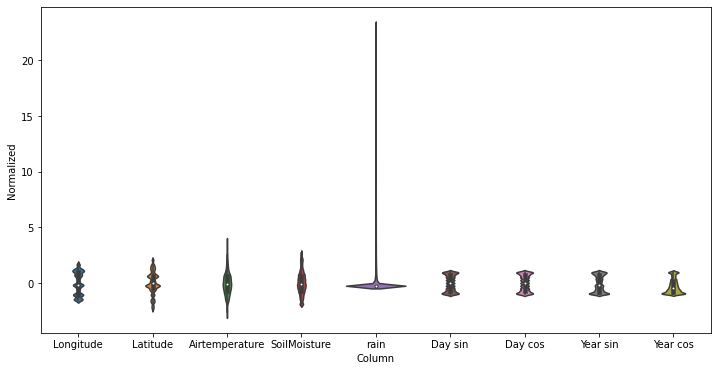

In [9]:
df_std = train_df.drop('Serial', axis = 1)
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#_ = ax.set_xticklabels(df_std.keys(), rotation=90)

In [10]:
# Class to generate windows of the data by given parameters. 
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
# split_window method will convert them to a window of inputs and a window of labels.
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
# Visualisation
def plot(self, model=None, plot_col='rain', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [13]:
# Making Datasets
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)
    return ds
    
WindowGenerator.make_dataset = make_dataset

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example



In [77]:
# Function to generate windows from data split by sensor
column_indices = 0
num_features = 0

def generateData(input_width, label_width, shift, label_column=None):
  full_train_ds = []
  full_val_ds = []
  full_test_ds = []
  for serial in train_df['Serial'].unique():
    filtered_train_df = train_df.loc[train_df['Serial'] == serial]
    filtered_val_df = val_df.loc[val_df['Serial'] == serial]
    filtered_test_df = test_df.loc[test_df['Serial'] == serial]
    
    filtered_train_df = filtered_train_df.drop('Serial', axis = 1)
    filtered_val_df = filtered_val_df.drop('Serial', axis = 1)
    filtered_test_df = filtered_test_df.drop('Serial', axis = 1)
    
    global column_indices
    global num_features
    column_indices = {name: i for i, name in enumerate(filtered_train_df.columns)}
    num_features = filtered_train_df.shape[1]

    window = WindowGenerator(
        input_width=input_width, label_width=label_width, shift=shift,
        train_df=filtered_train_df, val_df=filtered_val_df, test_df=filtered_test_df,
        label_columns=label_column)

    if filtered_train_df.shape[0] > 0:
      full_train_ds.append(window.train)
    if filtered_val_df.shape[0] > 0:
      full_val_ds.append(window.val)
    if filtered_test_df.shape[0] > 0:
      full_test_ds.append(window.test)

  all_train = full_train_ds[0].concatenate(full_train_ds[1])
  all_val = full_val_ds[0].concatenate(full_val_ds[1])
  all_test = full_test_ds[0].concatenate(full_test_ds[1])
  for i in range(2, len(full_train_ds)):
    all_train = all_train.concatenate(full_train_ds[i])
  for i in range(2, len(full_val_ds)):
    all_val = all_val.concatenate(full_val_ds[i])
  for i in range(2, len(full_test_ds)):
    all_test = all_test.concatenate(full_test_ds[i])

  return {"train":all_train, "val":all_val, "test": all_test, "example": window}

In [16]:
# Helper function to define a training regimen
MAX_EPOCHS = 20

def compile_and_fit(model, train, val, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train, epochs=MAX_EPOCHS,
                      validation_data=val,
                      callbacks=[early_stopping])
  return history

#PART I: Single Step Models

In [65]:
# Window for single step models
single_step_window = generateData(input_width=48, label_width=48, shift=1, label_column=["rain"])

single_step_window

{'train': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 'val': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 'test': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 'example': Total window size: 49
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
 Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
 Label column name(s): ['rain']}

##Baseline

In [66]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [67]:
baseline = Baseline(label_index=column_indices['rain'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window["val"])
performance['Baseline'] = baseline.evaluate(single_step_window["test"], verbose=0)

419/419 [==============================] - 6s 9ms/step - loss: 0.5264 - mean_absolute_error: 0.1922


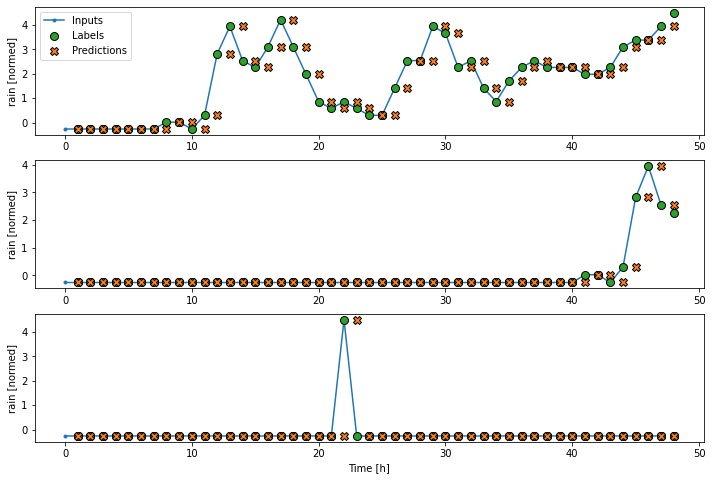

In [68]:
single_step_window["example"].plot(baseline)

##Linear

In [92]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [93]:
history = compile_and_fit(linear, single_step_window["train"], single_step_window["val"])

val_performance['Linear'] = linear.evaluate(single_step_window["val"])
performance['Linear'] = linear.evaluate(single_step_window["test"], verbose=0)

Epoch 1/20
1602/1602 [==============================] - 13s 8ms/step - loss: 1.0642 - mean_absolute_error: 0.5808 - val_loss: 0.5300 - val_mean_absolute_error: 0.3321
Epoch 2/20
1602/1602 [==============================] - 13s 8ms/step - loss: 0.4283 - mean_absolute_error: 0.2487 - val_loss: 0.4706 - val_mean_absolute_error: 0.2478
Epoch 3/20
1602/1602 [==============================] - 12s 8ms/step - loss: 0.4111 - mean_absolute_error: 0.2109 - val_loss: 0.4703 - val_mean_absolute_error: 0.2511
Epoch 4/20
1602/1602 [==============================] - 13s 8ms/step - loss: 0.4106 - mean_absolute_error: 0.2080 - val_loss: 0.4724 - val_mean_absolute_error: 0.2607
Epoch 5/20
419/419 [==============================] - 3s 7ms/step - loss: 0.4729 - mean_absolute_error: 0.2637


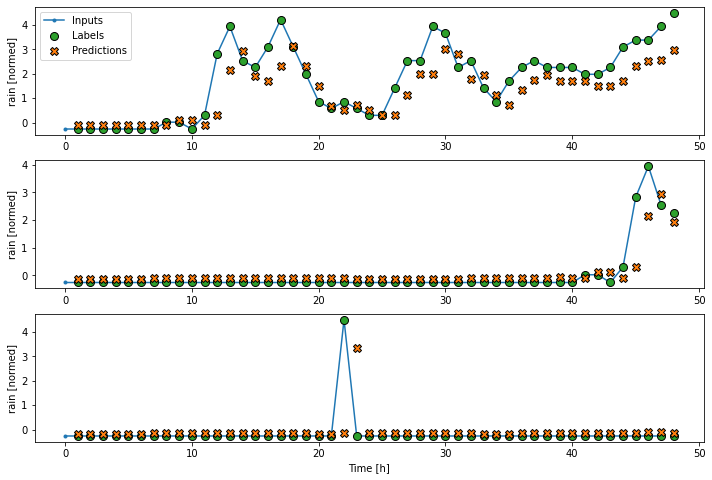

In [94]:
single_step_window["example"].plot(linear)

## Dense

In [98]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window["train"], single_step_window["val"])

val_performance['Dense'] = dense.evaluate(single_step_window["val"])
performance['Dense'] = dense.evaluate(single_step_window["test"], verbose=0)

Epoch 1/20
1602/1602 [==============================] - 18s 10ms/step - loss: 0.4071 - mean_absolute_error: 0.2251 - val_loss: 0.4714 - val_mean_absolute_error: 0.2864
Epoch 2/20
1602/1602 [==============================] - 15s 9ms/step - loss: 0.3957 - mean_absolute_error: 0.2104 - val_loss: 0.4698 - val_mean_absolute_error: 0.2727
Epoch 3/20
1602/1602 [==============================] - 15s 9ms/step - loss: 0.3915 - mean_absolute_error: 0.2045 - val_loss: 0.4655 - val_mean_absolute_error: 0.2538
Epoch 4/20
1602/1602 [==============================] - 15s 9ms/step - loss: 0.3881 - mean_absolute_error: 0.2008 - val_loss: 0.4669 - val_mean_absolute_error: 0.2497
Epoch 5/20
419/419 [==============================] - 4s 10ms/step - loss: 0.4728 - mean_absolute_error: 0.2490


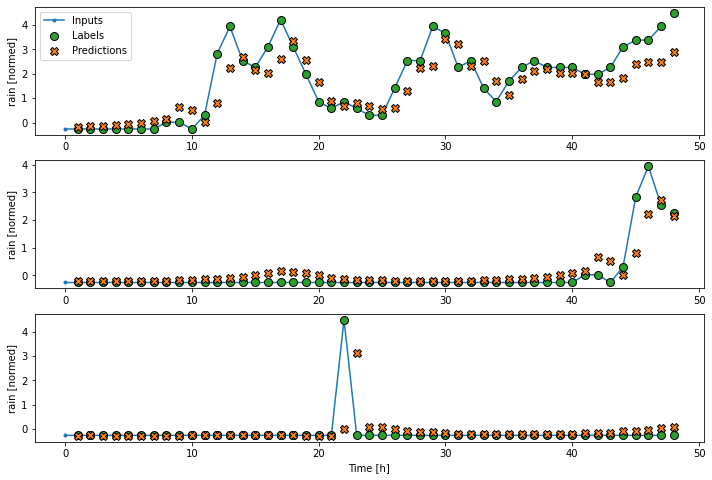

In [99]:
single_step_window["example"].plot(dense)

##Convolutional

In [69]:
# Define convolutional window
CONV_WIDTH = 48
conv_window = generateData(input_width=CONV_WIDTH, label_width=1, shift=1, label_column=["rain"])
conv_window

{'train': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>,
 'val': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>,
 'test': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>,
 'example': Total window size: 49
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
 Label indices: [48]
 Label column name(s): ['rain']}

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

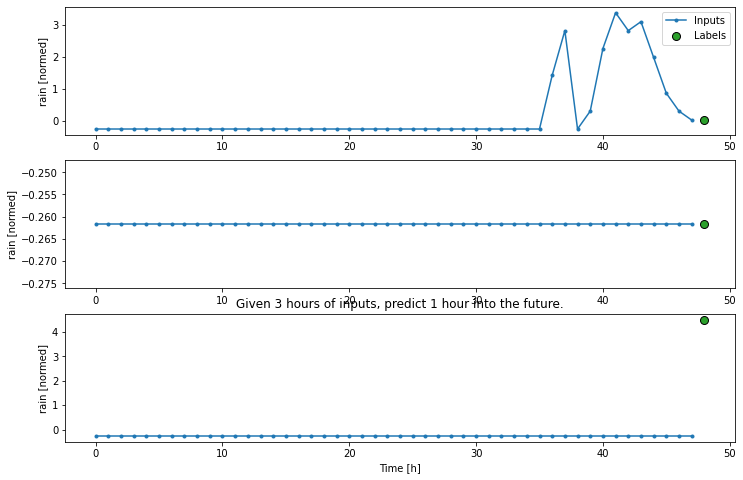

In [70]:
# Check convolutional window
conv_window["example"].plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [71]:
#cnn
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [72]:
history = compile_and_fit(conv_model, conv_window["train"], conv_window["val"])

val_performance['Conv'] = conv_model.evaluate(conv_window["val"])
performance['Conv'] = conv_model.evaluate(conv_window["test"], verbose=0)

Epoch 1/20
1602/1602 [==============================] - 19s 11ms/step - loss: 0.5947 - mean_absolute_error: 0.3464 - val_loss: 0.6221 - val_mean_absolute_error: 0.3840
Epoch 2/20
1602/1602 [==============================] - 16s 10ms/step - loss: 0.4970 - mean_absolute_error: 0.2956 - val_loss: 0.6034 - val_mean_absolute_error: 0.3678
Epoch 3/20
1602/1602 [==============================] - 15s 9ms/step - loss: 0.4779 - mean_absolute_error: 0.2822 - val_loss: 0.6154 - val_mean_absolute_error: 0.4117
Epoch 4/20
1602/1602 [==============================] - 14s 9ms/step - loss: 0.4521 - mean_absolute_error: 0.2682 - val_loss: 0.5525 - val_mean_absolute_error: 0.3432
Epoch 5/20
1602/1602 [==============================] - 14s 9ms/step - loss: 0.4526 - mean_absolute_error: 0.2642 - val_loss: 0.5329 - val_mean_absolute_error: 0.3080
Epoch 6/20
1602/1602 [==============================] - 15s 9ms/step - loss: 0.4389 - mean_absolute_error: 0.2543 - val_loss: 0.5376 - val_mean_absolute_error: 0.3

In [73]:
# Window for visualising results of CNN
LABEL_WIDTH = 48
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = generateData(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_column=["rain"])

wide_conv_window

{'train': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 95, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 'val': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 95, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 'test': <ConcatenateDataset element_spec=(TensorSpec(shape=(None, 95, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 48, 1), dtype=tf.float32, name=None))>,
 'example': Total window size: 96
 Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
  48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
 Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
  72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91

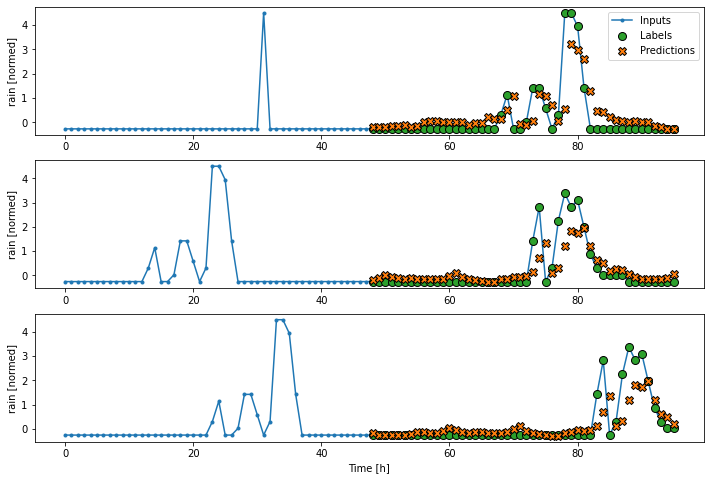

In [74]:
wide_conv_window["example"].plot(conv_model)

##Long Short Term Memory

In [95]:
#RNN
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [96]:
history = compile_and_fit(lstm_model, single_step_window["train"], single_step_window["val"])

val_performance['LSTM'] = lstm_model.evaluate(single_step_window["val"])
performance['LSTM'] = lstm_model.evaluate(single_step_window["test"], verbose=0)

Epoch 1/20
1602/1602 [==============================] - 22s 12ms/step - loss: 0.4240 - mean_absolute_error: 0.2229 - val_loss: 0.4746 - val_mean_absolute_error: 0.2600
Epoch 2/20
1602/1602 [==============================] - 17s 11ms/step - loss: 0.3891 - mean_absolute_error: 0.2071 - val_loss: 0.4654 - val_mean_absolute_error: 0.2577
Epoch 3/20
1602/1602 [==============================] - 18s 11ms/step - loss: 0.3779 - mean_absolute_error: 0.2063 - val_loss: 0.4655 - val_mean_absolute_error: 0.2544
Epoch 4/20
1602/1602 [==============================] - 20s 12ms/step - loss: 0.3665 - mean_absolute_error: 0.2048 - val_loss: 0.4646 - val_mean_absolute_error: 0.2560
Epoch 5/20
1602/1602 [==============================] - 18s 11ms/step - loss: 0.3556 - mean_absolute_error: 0.2043 - val_loss: 0.4710 - val_mean_absolute_error: 0.2547
Epoch 6/20
419/419 [==============================] - 4s 8ms/step - loss: 0.4719 - mean_absolute_error: 0.2528


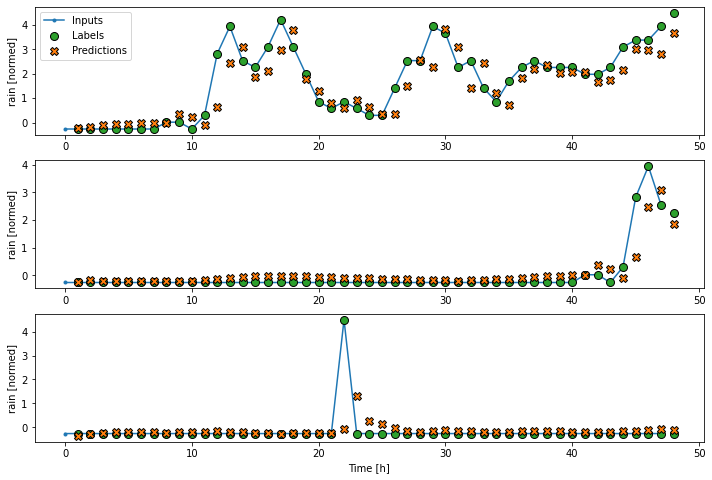

In [97]:
single_step_window["example"].plot(lstm_model)

##Visualise all single step model results

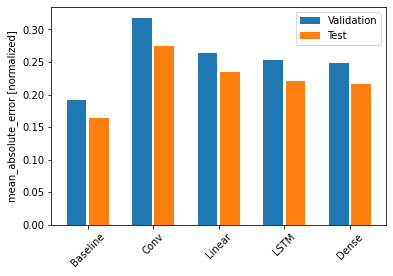

In [100]:
# Visualising results
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [101]:
# Results summary
for name, value in performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.1642
Conv    : 0.2740
Linear  : 0.2346
LSTM    : 0.2205
Dense   : 0.2166


#PART II: Multistep Models

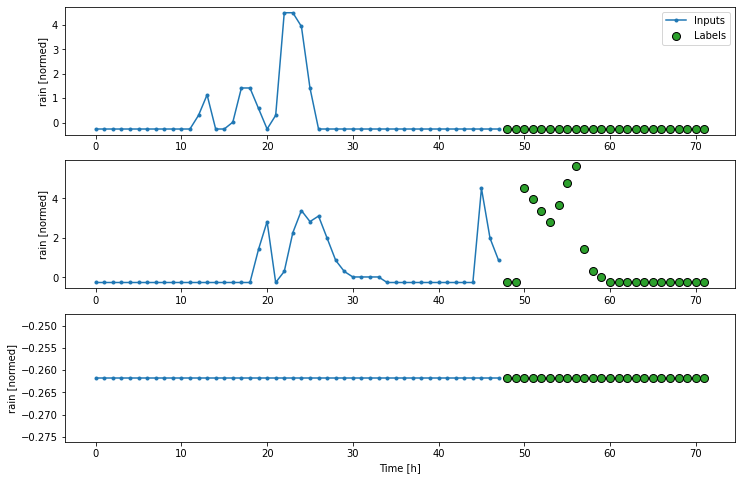

In [78]:
# define window for multi step model
OUT_STEPS = 24
multi_window = generateData(input_width=48, label_width=OUT_STEPS, shift=OUT_STEPS)

multi_window["example"].plot()

In [79]:
multi_window["example"]

Total window size: 72
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Label column name(s): None

##Multistep baseline

368/368 [==============================] - 6s 9ms/step - loss: 0.5801 - mean_absolute_error: 0.3434


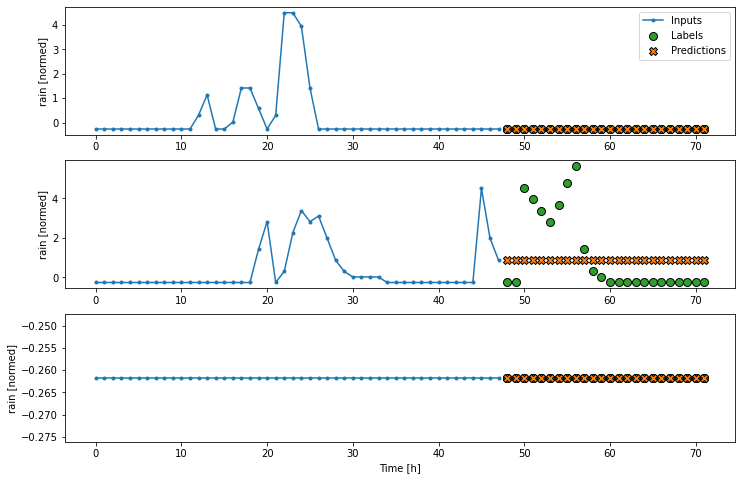

In [80]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Baseline'] = last_baseline.evaluate(multi_window["val"])
multi_performance['Baseline'] = last_baseline.evaluate(multi_window["test"], verbose=0)
multi_window["example"].plot(last_baseline)

##Multistep Linear

Epoch 1/20
1541/1541 [==============================] - 13s 8ms/step - loss: 0.3552 - mean_absolute_error: 0.3823 - val_loss: 0.2639 - val_mean_absolute_error: 0.2638
Epoch 2/20
1541/1541 [==============================] - 12s 8ms/step - loss: 0.1827 - mean_absolute_error: 0.1793 - val_loss: 0.2372 - val_mean_absolute_error: 0.1924
Epoch 3/20
1541/1541 [==============================] - 12s 8ms/step - loss: 0.1715 - mean_absolute_error: 0.1434 - val_loss: 0.2350 - val_mean_absolute_error: 0.1774
Epoch 4/20
1541/1541 [==============================] - 12s 8ms/step - loss: 0.1707 - mean_absolute_error: 0.1373 - val_loss: 0.2351 - val_mean_absolute_error: 0.1753
Epoch 5/20
368/368 [==============================] - 3s 8ms/step - loss: 0.2351 - mean_absolute_error: 0.1756


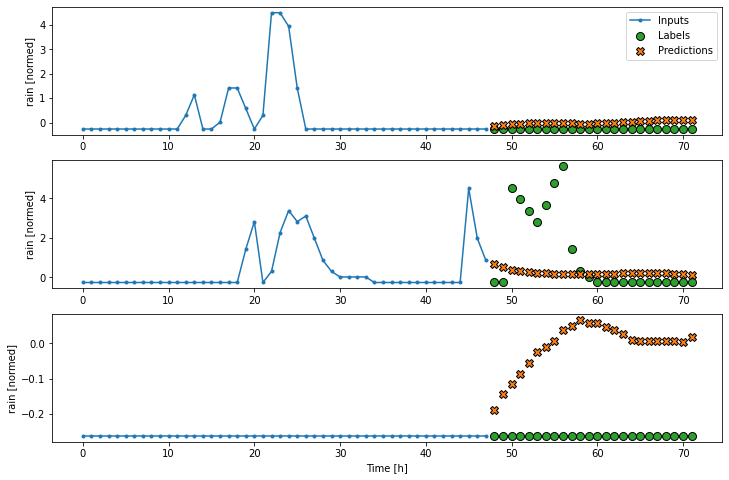

In [82]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window["train"], multi_window["val"])

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window["val"])
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window["test"], verbose=0)
multi_window["example"].plot(multi_linear_model)

##Multistep Dense

Epoch 1/20
1541/1541 [==============================] - 15s 9ms/step - loss: 0.1984 - mean_absolute_error: 0.1954 - val_loss: 0.2370 - val_mean_absolute_error: 0.2156
Epoch 2/20
1541/1541 [==============================] - 13s 8ms/step - loss: 0.1631 - mean_absolute_error: 0.1562 - val_loss: 0.2363 - val_mean_absolute_error: 0.2099
Epoch 3/20
1541/1541 [==============================] - 13s 8ms/step - loss: 0.1616 - mean_absolute_error: 0.1545 - val_loss: 0.2346 - val_mean_absolute_error: 0.2083
Epoch 4/20
1541/1541 [==============================] - 13s 8ms/step - loss: 0.1609 - mean_absolute_error: 0.1537 - val_loss: 0.2354 - val_mean_absolute_error: 0.2106
Epoch 5/20
368/368 [==============================] - 3s 8ms/step - loss: 0.2352 - mean_absolute_error: 0.2087


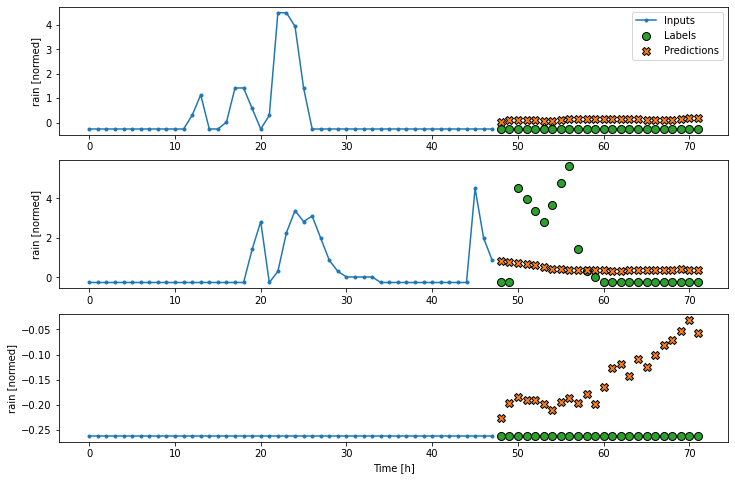

In [83]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window["train"], multi_window["val"])

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window["val"])
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window["test"], verbose=0)
multi_window["example"].plot(multi_dense_model)

##Multistep Convolutional

Epoch 1/20
1541/1541 [==============================] - 14s 9ms/step - loss: 0.2234 - mean_absolute_error: 0.2454 - val_loss: 0.2946 - val_mean_absolute_error: 0.2989
Epoch 2/20
1541/1541 [==============================] - 13s 8ms/step - loss: 0.1882 - mean_absolute_error: 0.2076 - val_loss: 0.2777 - val_mean_absolute_error: 0.2860
Epoch 3/20
1541/1541 [==============================] - 13s 8ms/step - loss: 0.1758 - mean_absolute_error: 0.1935 - val_loss: 0.2824 - val_mean_absolute_error: 0.2895
Epoch 4/20
1541/1541 [==============================] - 13s 8ms/step - loss: 0.1692 - mean_absolute_error: 0.1851 - val_loss: 0.2776 - val_mean_absolute_error: 0.2826
Epoch 5/20
1541/1541 [==============================] - 13s 8ms/step - loss: 0.1675 - mean_absolute_error: 0.1835 - val_loss: 0.2818 - val_mean_absolute_error: 0.2855
Epoch 6/20
368/368 [==============================] - 3s 8ms/step - loss: 0.2780 - mean_absolute_error: 0.2784


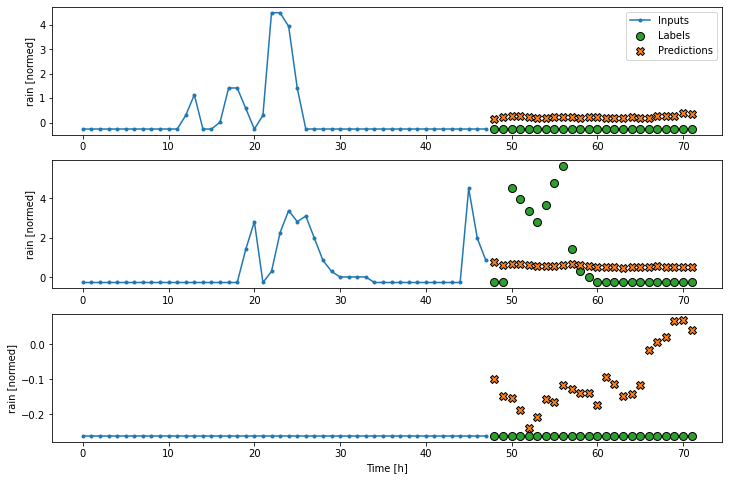

In [84]:
CONV_WIDTH = 48
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window["train"], multi_window["val"])

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window["val"])
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window["test"], verbose=0)
multi_window["example"].plot(multi_conv_model)

##Multistep LSTM

Epoch 1/20
1541/1541 [==============================] - 18s 10ms/step - loss: 0.2962 - mean_absolute_error: 0.3120 - val_loss: 0.2645 - val_mean_absolute_error: 0.2723
Epoch 2/20
1541/1541 [==============================] - 15s 10ms/step - loss: 0.1739 - mean_absolute_error: 0.1816 - val_loss: 0.2418 - val_mean_absolute_error: 0.2314
Epoch 3/20
1541/1541 [==============================] - 15s 10ms/step - loss: 0.1644 - mean_absolute_error: 0.1625 - val_loss: 0.2357 - val_mean_absolute_error: 0.2178
Epoch 4/20
1541/1541 [==============================] - 15s 10ms/step - loss: 0.1596 - mean_absolute_error: 0.1537 - val_loss: 0.2315 - val_mean_absolute_error: 0.2078
Epoch 5/20
1541/1541 [==============================] - 17s 11ms/step - loss: 0.1570 - mean_absolute_error: 0.1490 - val_loss: 0.2281 - val_mean_absolute_error: 0.1998
Epoch 6/20
1541/1541 [==============================] - 15s 10ms/step - loss: 0.1553 - mean_absolute_error: 0.1460 - val_loss: 0.2275 - val_mean_absolute_error:

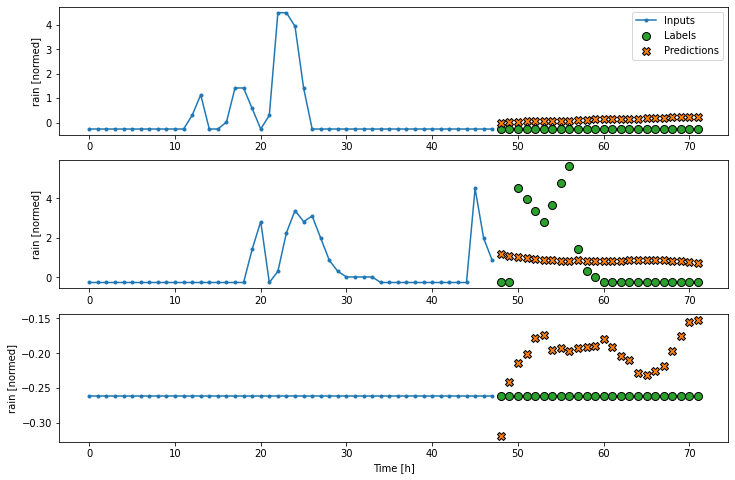

In [85]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window["train"], multi_window["val"])

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window["val"])
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window["test"], verbose=0)
multi_window["example"].plot(multi_lstm_model)

##Results for multistep models

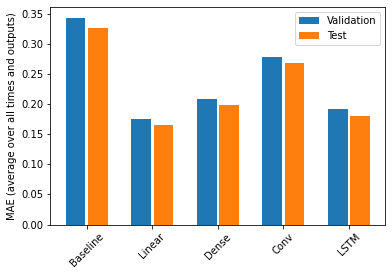

In [86]:
# Visualising results
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [87]:
# Results summary
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.3266
Linear  : 0.1648
Dense   : 0.1988
Conv    : 0.2672
LSTM    : 0.1809
